In [114]:
#%pip install openpyxl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import root_mean_squared_error
import random
import scipy
import glob
import os


labels = ['k2',
'k3',
'k4',
'k5',
'KS',
'KP',
'KN',
'kmenos4']

In [115]:
class Normalizer:
    def __init__(self):
        self.min = None
        self.max = None

    def fit(self, data):
        self.min = data.min(axis=0)
        self.max = data.max(axis=0)
        
    def transform(self, data):
        return (data - self.min) / (self.max - self.min)


    def inverse_transform(self, data):
        return data*(self.max - self.min) + self.min

# Importando experimentos

In [116]:
CIs = []
def convert_ci(ci):
    if type(ci) == str:
        ci_list = [float(i) for i in ci.split('_')]
        return ci_list
    else:
        ci_str = str(ci[0]) + '_' + str(ci[1]) + '_' + str(ci[2]) + '_' + str(ci[3])
        return ci_str
def import_dfs():
    # Path to the folder containing CSV files
    folder_path = '../data/'

    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    # Initialize an empty list to hold dataframes
    data_frames = {}
    names_files = [name.split('\\')[-1].rstrip('.csv') for name in csv_files]

    # Read the first CSV file to establish the schema
    schema = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm','apa_t']
    all_times = []
    # Load each remaining CSV file, reorder columns, and append to the list
    for idx,name in enumerate(names_files):
        df = pd.read_csv(csv_files[idx])  
        print(name)
        df = df[schema]  # Reorder columns to match the schema
        all_times.append(df['apa_t'].to_list())
        ci = df.iloc[0,:4].to_numpy()
        data_frames[name] = df
        CIs.append(convert_ci(ci))
    
    
    return data_frames,names_files,all_times
data_frames,file_list_exp,all_times = import_dfs()

print(data_frames.keys())
print("6-apa initial: ",[convert_ci(ci)[0] for ci in CIs])
print("ester initial: ",[convert_ci(ci)[2] for ci in CIs])
print([len(data_frame) for data_frame in [data_frames[name] for name in file_list_exp]])
print([data_frame['apa_t'].iloc[-1] for data_frame in [data_frames[name] for name in file_list_exp]])


25.45nh60ab20
25.46nh30ab30
25.47nh5ab80
5.100nh40ab80
5.102nh20ab40
5.103nh40ab30
5.106nh100ab40
5.107nh55ab55
5.109nh5ab55
5.110nh10ab55
5.112nh78ab35
5.48nh20ab80
5.80nh12ab40
5.81nh5ab30
nh60ab80
dict_keys(['25.45nh60ab20', '25.46nh30ab30', '25.47nh5ab80', '5.100nh40ab80', '5.102nh20ab40', '5.103nh40ab30', '5.106nh100ab40', '5.107nh55ab55', '5.109nh5ab55', '5.110nh10ab55', '5.112nh78ab35', '5.48nh20ab80', '5.80nh12ab40', '5.81nh5ab30', 'nh60ab80'])
6-apa initial:  [20.0, 30.0, 80.0, 80.0, 40.5, 30.4, 40.038986354775815, 55.0, 55.0, 55.0, 32.5, 80.0, 38.75, 30.0, 80.0]
ester initial:  [60.0, 30.0, 5.0, 40.0, 21.75, 43.0, 100.04518072289156, 55.0, 5.0, 10.0, 78.0, 20.0, 12.0, 5.0, 60.0]
[11, 11, 10, 15, 13, 13, 12, 8, 8, 9, 10, 9, 11, 10, 11]
[490.0, 490.0, 240.0, 600.0, 540.0, 540.0, 360.0, 50.0, 60.0, 60.0, 360.0, 60.0, 410.0, 285.0, 600.0]


# Definindo modelo

In [117]:
Cez = 1

k2 = 187 / 60             # 1/min             
k3 = 44 / 60              # 1/min            
k4 = 235 / 60             # 1/min            
k5 = 0.15                 # 1/min            
KS = 380                  # milimolar            
KP = 95                   # milimolar            
KN = 43                   # milimolar            
kmenos4 = 217 / 60        # 1/min         

P = np.zeros(8)
P[0]   = k2 
P[1]   = k3    
P[2]   = k4      
P[3]   = k5      
P[4]   = KS     
P[5]   = KP      
P[6]   = KN      
P[7]   = kmenos4

Np = len(P)

In [118]:
def enzymic_amox(t,y, 
k2,
k3,
k4,
k5,
KS,
KP,
KN,
kmenos4,
):
    Cez = 1
    CAB = y[0]
    CAN = y[1]
    CNH = y[2]
    CAOH = y[3]

    RP = (Cez)/(k3 * KN + k4 * CNH + k5 * CNH) * (((k2 * k4 * CAB * CNH)/ (KS)) - ((kmenos4 * CAN * (k3 * KN + k5 * CNH))/KP))
    RB = (Cez * (k3 * KN + k5 * CNH) / (k3 * KN + k4 * CNH + k5 * CNH)) * (((k2 * CAB)/KS) - ((kmenos4 * CAN) / KP))
    RS = -(RP + RB)
    RNu = -(RP)

    dy = np.zeros(4)

    dy[0] =  RS       
    dy[1] =  RP
    dy[2] =  -(RP)  
    dy[3] = RB      
    
    return np.array(dy) 

In [119]:
# ODE15s solver
def ode15s_amox(P, CI, t):
    try:
        sol = scipy.integrate.solve_ivp(
            enzymic_amox, 
            t_span=(t[0], t[-1]), 
            t_eval=t, 
            y0=CI, 
            method='BDF', 
            args=P, 
            #atol=1e-8, 
            #tol=1e-6
        )
        if sol.status != 0:
            raise ValueError("ODE solver failed to converge")
        return sol.y.T
    except Exception as e:
        print(f"Solver failed with error: {e}")
        # Handle solver failure (e.g., return NaNs or retry with different parameters)
        return np.full((len(CI), len(t)), np.nan).T

# Parâmetros estimados c/ 50000 cadeias

In [120]:
def import_dfs(N):
    # Path to the folder containing CSV files
    folder_path = '../results/model_donald'
    # Get a list of all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, f'*{N}_*mean.csv'))
    # Initialize an empty list to hold dataframes
    data_frames_imp = []
    # Read the first CSV file to establish the schema
    schema = ['k2',
              'k3',
              'k4',
              'k5',
              'KS',
              'KP',
              'KN',
              'kmenos4'
             ]

    # Load each remaining CSV file, reorder columns, and append to the list
    for file in csv_files:
        df = pd.read_csv(file)  
        
        df = df[schema]  # Reorder columns to match the schema
        data_frames_imp.append(df)
    
    csv_files = [name.split('\\')[-1].rstrip('.csv') for name in csv_files]
    print(csv_files)
    return data_frames_imp,csv_files 
N = 50000
data_frames_chains,file_list = import_dfs(50000)


['0_50000_donald_mean', '1_50000_donald_mean', '2_50000_donald_mean']


## Guardar ensaios em um dataframe

In [121]:
ensaios_dfs = {}
for assay in file_list_exp:
    ensaios_dfs[assay] = pd.DataFrame(data=np.zeros((len(data_frames_chains),data_frames_chains[0].shape[1])),index=file_list,columns=labels)

for idx,df in enumerate(data_frames_chains):
    for row in df.index:
        ensaios_dfs[file_list_exp[row]].loc[file_list[idx],:] = df.iloc[row]
len(ensaios_dfs)

15

### Desvios padrões

In [122]:
all_std = np.zeros(10)

for df in ensaios_dfs.keys():
    for idx,par in enumerate(labels):
        all_std[idx] += ensaios_dfs[df].std(ddof=0).loc[par]

all_std = all_std/len(ensaios_dfs)
print('Desvio padrão dos valores de parâmetros - média de cada apriori')
for idx,par in enumerate(labels):
    print(par,all_std[idx]/len(all_std))

Desvio padrão dos valores de parâmetros - média de cada apriori
k2 0.04106525565411328
k3 0.025789483979918697
k4 0.025183675054488097
k5 0.003912546524014085
KS 11.292266694242903
KP 3.2374292075736846
KN 1.3081508143982636
kmenos4 0.05445184098957989


## Visualização da performance

In [123]:
def model_eval(x_model, t_model, val_x, val_t):
    fig, axis = plt.subplots(2, 2, figsize=[6, 6])
    labels = ['POH-PGME','Amoxicillin','6-APA','POHPG']
    mlabels = ['POH-PGME model','Amoxicillin model','6-APA model','POHPG model']
    style = ['.r','.g','.b','.k']
    mstyle = ['-ok','-ok','-ok','-ok']    
    for idx,ax in enumerate(axis.flatten()):
        ax.plot(val_t, val_x[:, idx], style[idx], label=labels[idx],linewidth=0.5,markersize=5)
        ax.plot(t_model, x_model[:, idx], mstyle[idx], label=mlabels[idx],linewidth=0.9,markersize=3)
        ax.set_title(f'{labels[idx]}')
        ax.set_ylim([val_x[:, idx].min()-10, val_x[:, idx].max()+10])
        ax.set_xlim([0, val_t[-1]+5])
        ax.legend()

## Avaliar os parâmetros universalmente

In [124]:
import seaborn as sns
import copy

eval_set = ['25.46nh30ab30', '25.47nh5ab80', '5.100nh40ab80', '5.102nh20ab40', '5.103nh40ab30', '5.106nh100ab40', '5.107nh55ab55', '5.109nh5ab55', '5.110nh10ab55', '5.112nh78ab35', '5.48nh20ab80', '5.80nh12ab40', '5.81nh5ab30']
out_set = ['nh60ab80','25.45nh60ab20']

def eval_performance(P,plot=False):
    
    total_error = 0
    all_error = []
    x_names = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm']

    for exp_name in eval_set:
        x_target = data_frames[exp_name].loc[:,x_names].to_numpy()
        t_target = data_frames[exp_name]['apa_t'].to_numpy()
        
        ic = x_target[0]
        t_model = np.linspace(t_target[0],t_target[-1],len(t_target))
        
        sol_val = ode15s_amox(P,ic,t_target)
        x_model = sol_val

        error = root_mean_squared_error(x_target, x_model)

        # Normalize RMSE by the square root of the series length (already included)
        normalized_error = error / np.sqrt(len(t_target))
        error = normalized_error

        all_error.append(error)
        total_error += error

        if plot:
            print(f'Error {exp_name} : {error}')
        
            model_eval(x_model,t_target,x_target,t_target)
            
    print('\ntotal error: ',total_error,'\n')
        
    return total_error,all_error

def eval_all(P_new):
    x_names = ['ester_mm', 'amox_mm', 'apa_mm', 'aoh_mm']

    total_error = 0
    total_mass_error = 0
    idx = 0
    surface_error = np.zeros((len(data_frames),3))
    for exp_name in eval_set:
        x_target = data_frames[exp_name].loc[:,x_names].to_numpy()
        t_target = data_frames[exp_name]['apa_t'].to_numpy()
    
        ic = x_target[0]
        
        surface_error[idx,1] = ic[0] # ester
        surface_error[idx,2] = ic[2] # apa
        
        sol_val = ode15s_amox(P_new,ic,t_target)
        x_model = sol_val
        error = root_mean_squared_error(x_target, sol_val)

        # Normalize RMSE by the square root of the series length (already included)
        normalized_error = error / np.sqrt(len(t_target))
        error = normalized_error

        total_error += error

        surface_error[idx,0] = error
        
        print(f'{ic} tmax_{int(t_target[-1])} :\t{error}')
        idx+=1
        
    surfacedf = pd.DataFrame(surface_error,columns=['RMSE','Ester','APA'])
    
    plt.figure(figsize=(6,6))
    sns.scatterplot(data=surfacedf, x='Ester', y='APA', size='RMSE', hue='RMSE', sizes=(10, 400), hue_norm=(0, 2.5),legend='full')
    plt.legend(title='Error Value', loc='upper right', bbox_to_anchor=(-0.15, 1))
    print(f'Total error: {total_error/len(data_frames)}\tmass error:{total_mass_error/len(data_frames)}')

In [125]:
import seaborn as sns
import copy


def find_best():
    indexes = copy.copy(file_list_exp) 
    
    grid = pd.DataFrame(np.zeros((len(eval_set),len(eval_set))),index=eval_set,columns=eval_set)
    # Para cada experimento
    for idx,name in enumerate(eval_set):
        df = ensaios_dfs[name]
        all_errors = []
        mean_errors = []

        # Para cada iteração do experimento
        for iter in range(df.shape[0]):
            # Coletar os parametros e avaliar perfomance
            P = df.iloc[iter,:].to_numpy()
            tot_error, all_error = eval_performance(P)

            # Armazenar os erros associados a cada experimento desta iteração
            all_errors.append(all_error)

            # Armazenar o erro médio dessa iteração
            mean_error = (tot_error) / (len(all_error))
            mean_errors.append(mean_error)
        
        # Média dos erros em cada experimento de todas as iterações
        all_error_mean = np.mean(all_errors,axis=0)

        # Média do erro média das iterações
        grid.loc['mean',name] = np.mean(mean_errors)
        for i,test_name in enumerate(eval_set):
            grid.loc[test_name,name] = all_error_mean[i]
    return grid
best = find_best()


total error:  16.22861114918899 


total error:  16.863594453736344 


total error:  16.068195470462346 


total error:  9.866778680164323 


total error:  10.143710221339045 


total error:  14.173057289533363 


total error:  19.605810425144476 


total error:  19.464014592244556 


total error:  19.643552199284397 


total error:  12.078721304167676 


total error:  12.95055825289727 


total error:  10.029953874688772 


total error:  15.070722833655468 


total error:  15.181316803653488 


total error:  14.673773442377561 


total error:  11.50450681241761 


total error:  11.8621066535686 


total error:  12.086480005063901 


total error:  12.331930495860615 


total error:  12.490111013858394 


total error:  11.908554438775115 


total error:  10.521078052582524 


total error:  10.294686252086507 


total error:  12.279731541028625 


total error:  12.036817106390323 


total error:  14.611945812358769 


total error:  15.643240260392398 


total error:  7.82334092896804 



<Axes: >

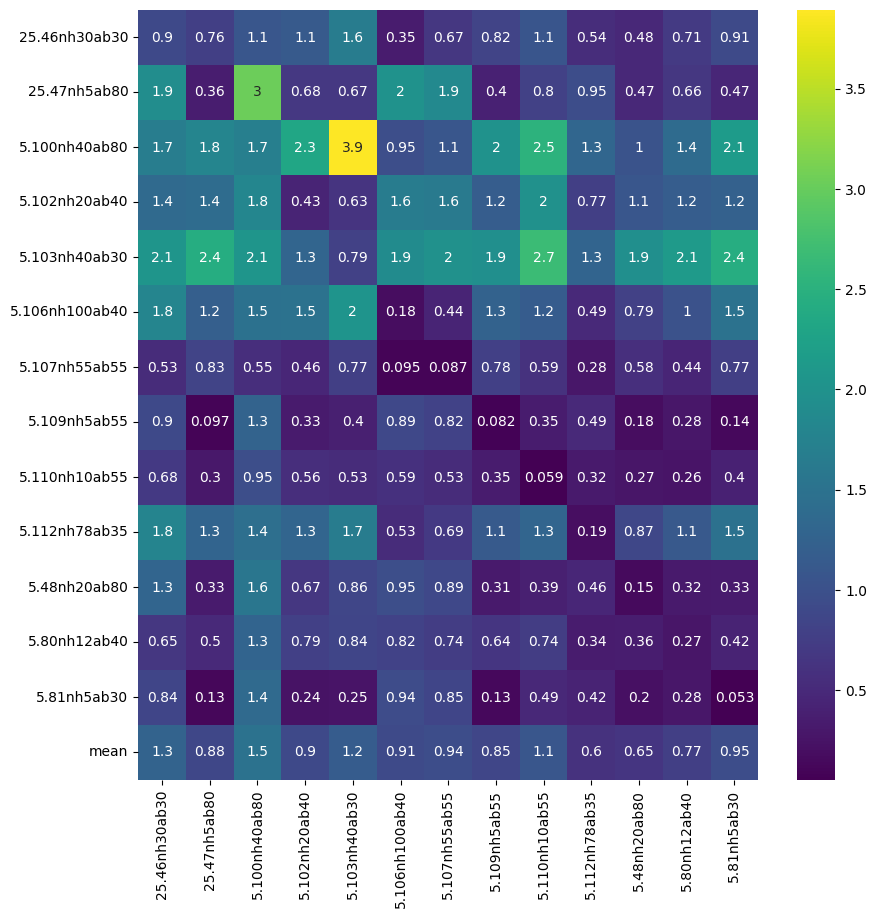

In [126]:
plt.figure(figsize=(10,10))
sns.heatmap(best,annot=True, cmap='viridis')
#plt.savefig(f'../results/model_luci_single_rep/aval_single/heatmap_{N}')

In [127]:
n = -4
for i in range(len(eval_set)):
    print(eval_set[i])
    for j in range(3):
        par = copy.deepcopy(ensaios_dfs[eval_set[i]].iloc[j,:].to_list())
        #eval_performance(P,plot=False)
        eval_performance(par,plot=False)
# eval_all(par)

#print(file_list_exp[n])
#for idx,par in enumerate(par):
#    print(labels[idx],': ',par)

25.46nh30ab30

total error:  16.22861114918899 


total error:  16.863594453736344 


total error:  16.068195470462346 

25.47nh5ab80

total error:  9.866778680164323 


total error:  10.143710221339045 


total error:  14.173057289533363 

5.100nh40ab80

total error:  19.605810425144476 


total error:  19.464014592244556 


total error:  19.643552199284397 

5.102nh20ab40

total error:  12.078721304167676 


total error:  12.95055825289727 


total error:  10.029953874688772 

5.103nh40ab30

total error:  15.070722833655468 


total error:  15.181316803653488 


total error:  14.673773442377561 

5.106nh100ab40

total error:  11.50450681241761 


total error:  11.8621066535686 


total error:  12.086480005063901 

5.107nh55ab55

total error:  12.331930495860615 


total error:  12.490111013858394 


total error:  11.908554438775115 

5.109nh5ab55

total error:  10.521078052582524 


total error:  10.294686252086507 


total error:  12.279731541028625 

5.110nh10ab55

total error:  12

5.112nh78ab35

total error:  33.62243768829469 

Error 25.46nh30ab30 : 0.4758288915764272
Error 25.47nh5ab80 : 0.9890633549600467
Error 5.100nh40ab80 : 1.166194715397894
Error 5.102nh20ab40 : 0.8603522211611953
Error 5.103nh40ab30 : 1.329362206834707
Error 5.106nh100ab40 : 0.47271421847466527
Error 5.107nh55ab55 : 0.2655923853806062
Error 5.109nh5ab55 : 0.5027408431690901
Error 5.110nh10ab55 : 0.2995536241923455
Error 5.112nh78ab35 : 0.16504902311650188
Error 5.48nh20ab80 : 0.45978986247689213
Error 5.80nh12ab40 : 0.32205688413679634
Error 5.81nh5ab30 : 0.4489447723321639

total error:  7.757243003209332 

[30.  0. 30.  0.] tmax_490 :	0.4758288915764272
[80.  0.  5.  0.] tmax_240 :	0.9890633549600467
[80.  0. 40.  0.] tmax_600 :	1.166194715397894
[40.5         0.         21.75        3.37262013] tmax_540 :	0.8603522211611953
[30.4   0.   43.    2.55] tmax_540 :	1.329362206834707
[4.00389864e+01 6.40149834e-02 1.00045181e+02 1.42108547e+00] tmax_360 :	0.47271421847466527
[55.        0. 

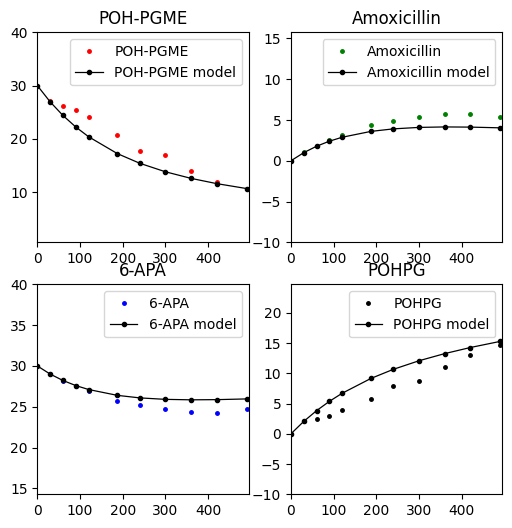

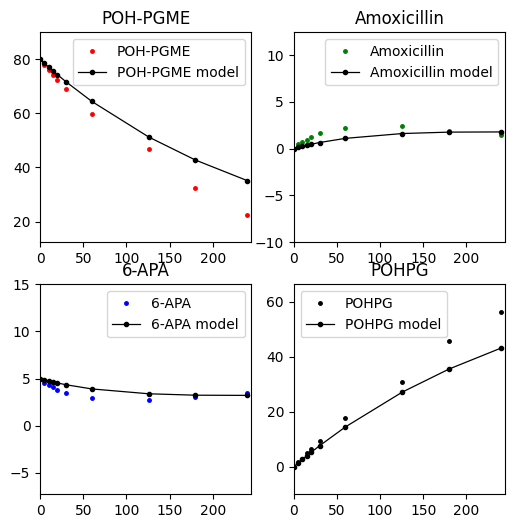

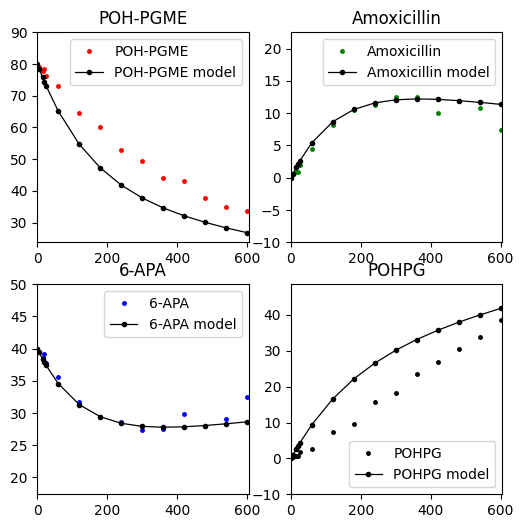

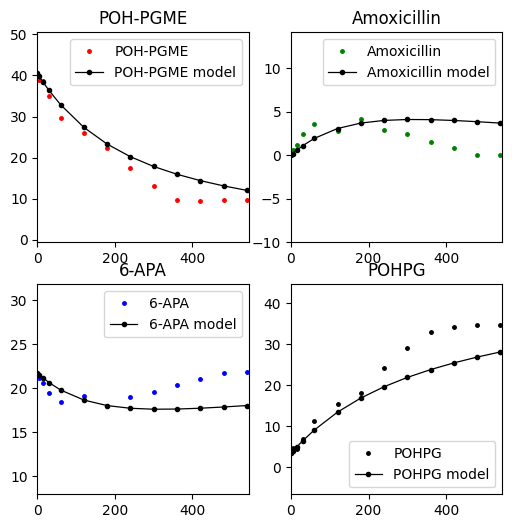

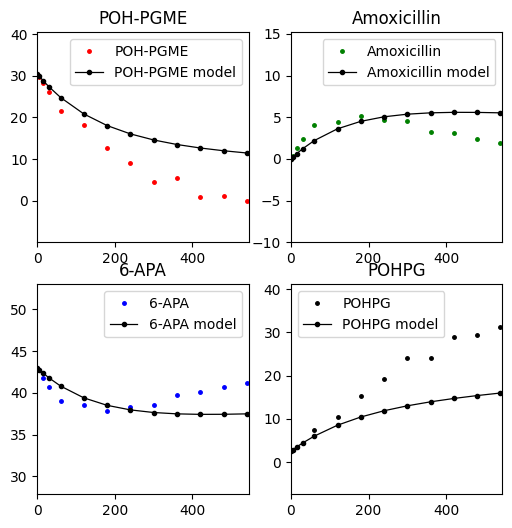

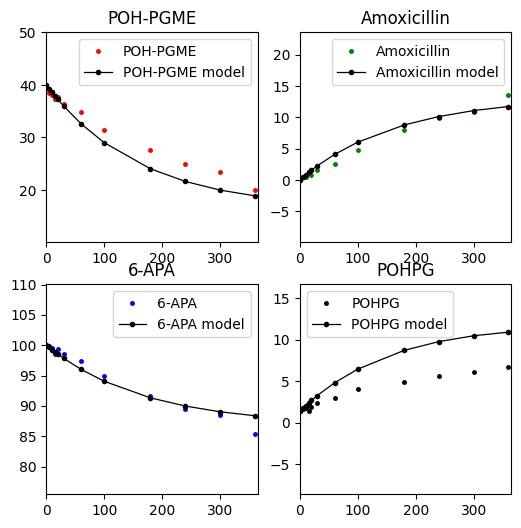

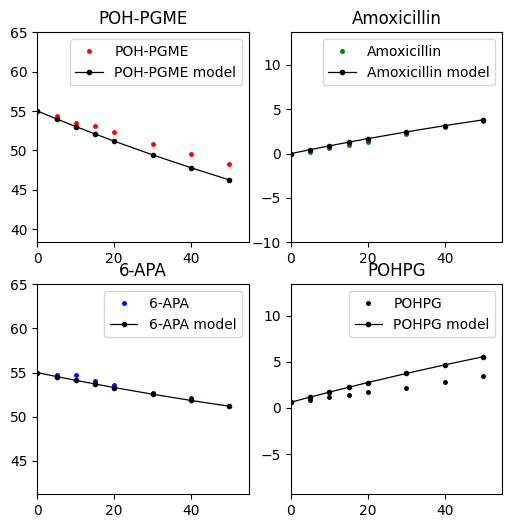

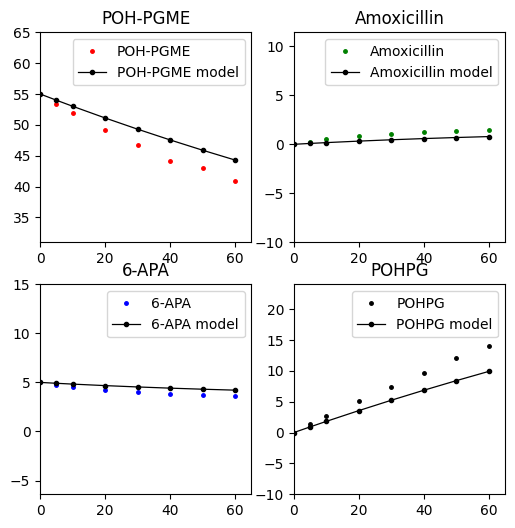

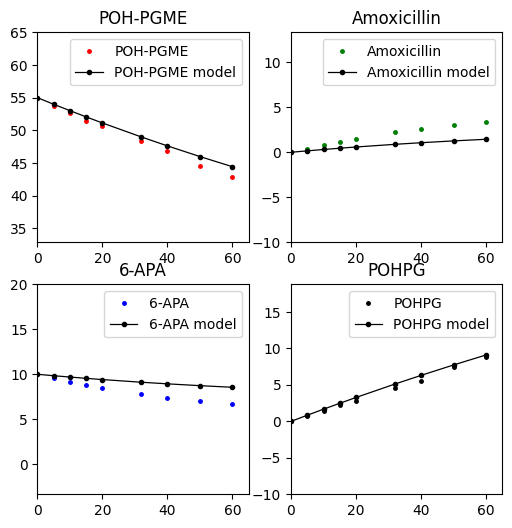

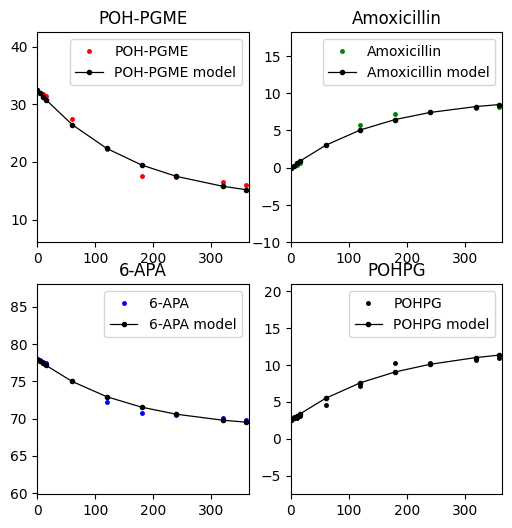

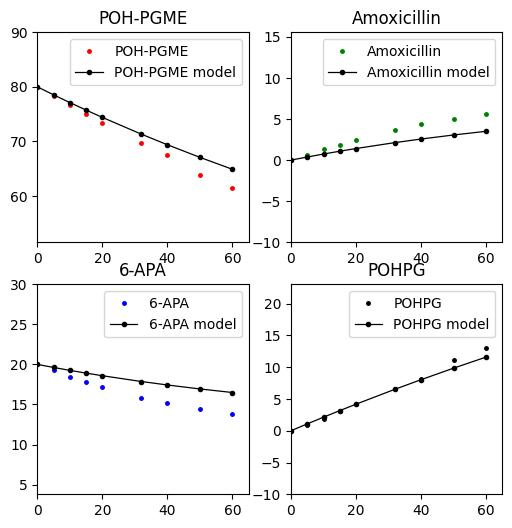

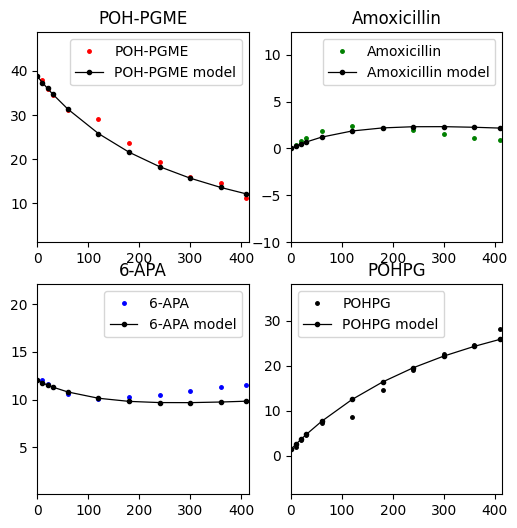

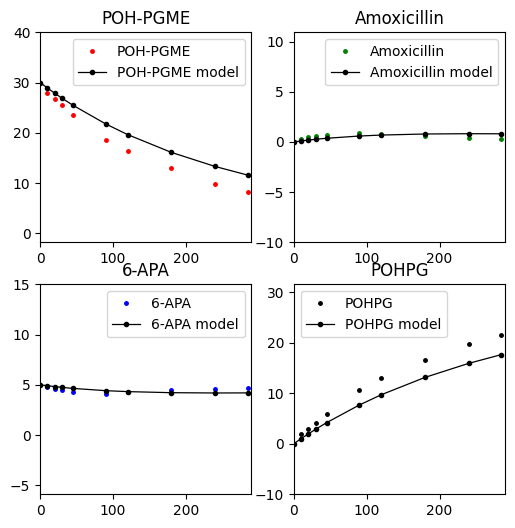

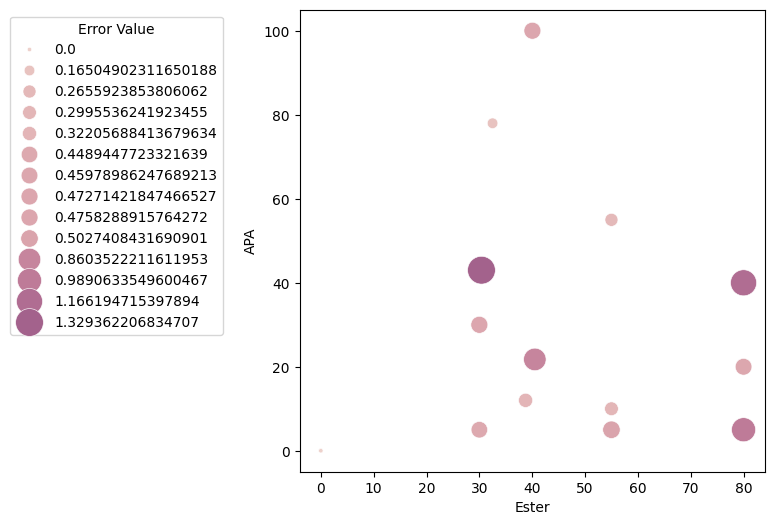

In [128]:
n = -4
par = copy.deepcopy(ensaios_dfs[eval_set[n]].iloc[1,:].to_list())
print(eval_set[n])
eval_performance(P,plot=False)
eval_performance(par,plot=True)
eval_all(par)

print(file_list_exp[n])
for idx,par in enumerate(par):
    print(labels[idx],': ',par)

# Parâmetros estimados c/ 100000

In [129]:
N = 100000
data_frames_chains,file_list = import_dfs(100000)


['0_100000_donald_mean', '1_100000_donald_mean', '2_100000_donald_mean']


## Guardar ensaios em um dataframe

In [130]:
ensaios_dfs = {}
for assay in file_list_exp:
    ensaios_dfs[assay] = pd.DataFrame(data=np.zeros((len(data_frames_chains),data_frames_chains[0].shape[1])),index=file_list,columns=labels)

for idx,df in enumerate(data_frames_chains):
    for row in df.index:
        ensaios_dfs[file_list_exp[row]].loc[file_list[idx],:] = df.iloc[row]
len(ensaios_dfs)

15

## Visualização da performance

In [131]:
best = find_best()


total error:  15.821052643995051 


total error:  15.250693826145694 


total error:  16.34389262900082 


total error:  7.740062960125624 


total error:  13.11992416520488 


total error:  9.64124902097254 


total error:  20.159952294292843 


total error:  19.160145426442615 


total error:  20.10553084306373 


total error:  13.219508993488615 


total error:  12.449074329154445 


total error:  10.36526309667617 


total error:  15.417557919835446 


total error:  15.372203171903475 


total error:  15.451580304061077 


total error:  11.859229311981107 


total error:  11.699453604966033 


total error:  14.154127879950765 


total error:  11.617111067264098 


total error:  12.350787180346105 


total error:  12.072869422598904 


total error:  10.811193294179928 


total error:  10.823129469133026 


total error:  14.100554909511494 


total error:  12.702939709091506 


total error:  11.903171629614341 


total error:  18.25450271096315 


total error:  7.906430405711434 




<Axes: >

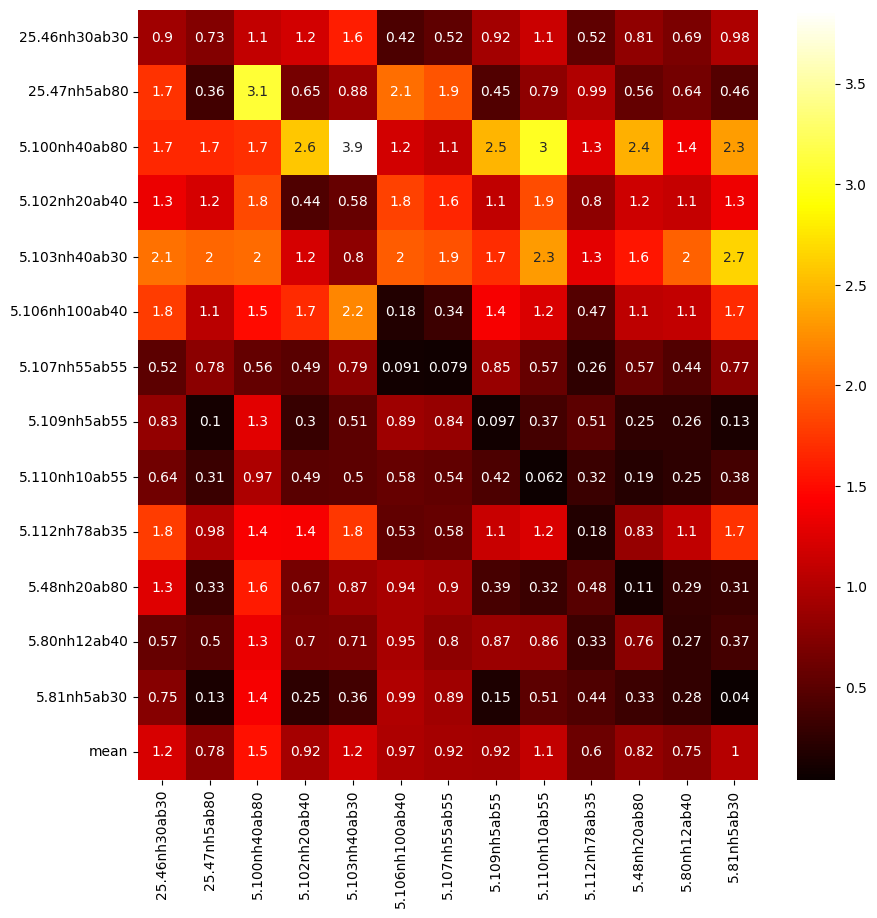

In [132]:
plt.figure(figsize=(10,10))
sns.heatmap(best,annot=True, cmap='hot')
#plt.savefig(f'../results/model_luci_single_rep/aval_single/heatmap_{N}')

In [133]:
n = -4
for i in range(len(eval_set)):
    print(eval_set[i])
    for j in range(3):
        par = copy.deepcopy(ensaios_dfs[eval_set[i]].iloc[j,:].to_list())
        #eval_performance(P,plot=False)
        eval_performance(par,plot=False)
# eval_all(par)

25.46nh30ab30

total error:  15.821052643995051 


total error:  15.250693826145694 


total error:  16.34389262900082 

25.47nh5ab80

total error:  7.740062960125624 


total error:  13.11992416520488 


total error:  9.64124902097254 

5.100nh40ab80

total error:  20.159952294292843 


total error:  19.160145426442615 


total error:  20.10553084306373 

5.102nh20ab40

total error:  13.219508993488615 


total error:  12.449074329154445 


total error:  10.36526309667617 

5.103nh40ab30

total error:  15.417557919835446 


total error:  15.372203171903475 


total error:  15.451580304061077 

5.106nh100ab40

total error:  11.859229311981107 


total error:  11.699453604966033 


total error:  14.154127879950765 

5.107nh55ab55

total error:  11.617111067264098 


total error:  12.350787180346105 


total error:  12.072869422598904 

5.109nh5ab55

total error:  10.811193294179928 


total error:  10.823129469133026 


total error:  14.100554909511494 

5.110nh10ab55

total error:  12.

5.112nh78ab35

total error:  33.62243768829469 

Error 25.46nh30ab30 : 0.5082354918165984
Error 25.47nh5ab80 : 0.996254008266591
Error 5.100nh40ab80 : 1.2792809218524017
Error 5.102nh20ab40 : 0.8043753338673791
Error 5.103nh40ab30 : 1.3003028360561746
Error 5.106nh100ab40 : 0.4768504737717551
Error 5.107nh55ab55 : 0.26021362619200317
Error 5.109nh5ab55 : 0.5166775676865762
Error 5.110nh10ab55 : 0.31955365462201535
Error 5.112nh78ab35 : 0.19283747655152364
Error 5.48nh20ab80 : 0.4789182581795184
Error 5.80nh12ab40 : 0.32771389303263176
Error 5.81nh5ab30 : 0.4452168638162645

total error:  7.906430405711434 

[30.  0. 30.  0.] tmax_490 :	0.5082354918165984
[80.  0.  5.  0.] tmax_240 :	0.996254008266591
[80.  0. 40.  0.] tmax_600 :	1.2792809218524017
[40.5         0.         21.75        3.37262013] tmax_540 :	0.8043753338673791
[30.4   0.   43.    2.55] tmax_540 :	1.3003028360561746
[4.00389864e+01 6.40149834e-02 1.00045181e+02 1.42108547e+00] tmax_360 :	0.4768504737717551
[55.        0.

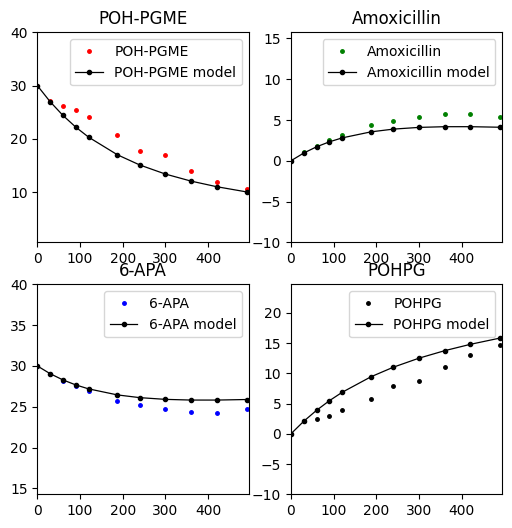

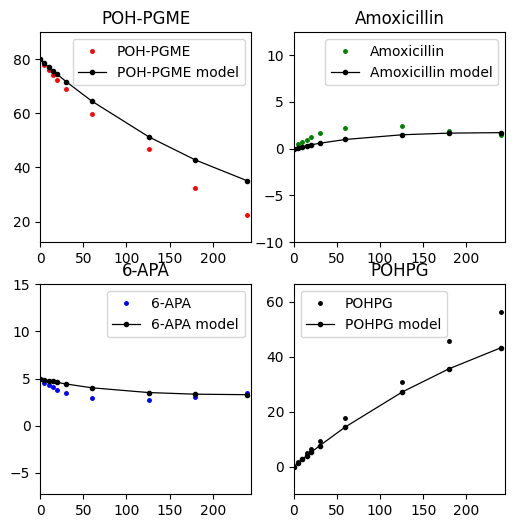

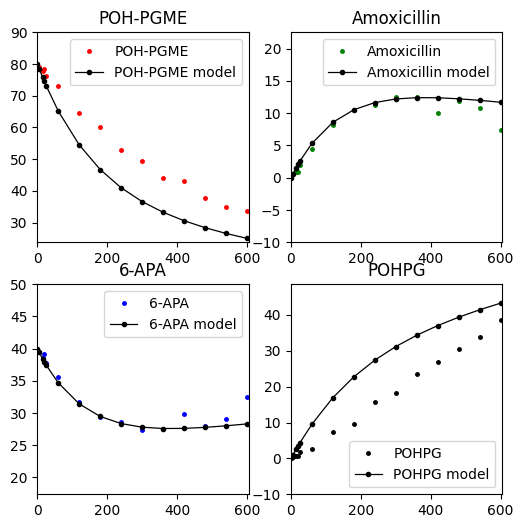

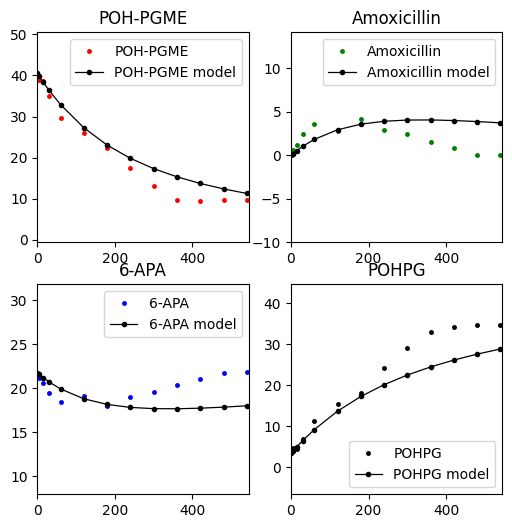

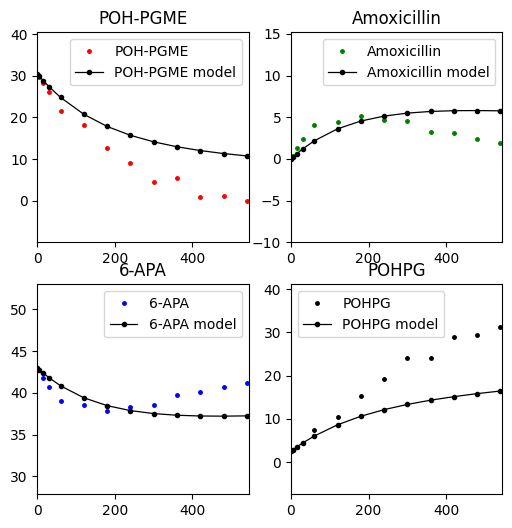

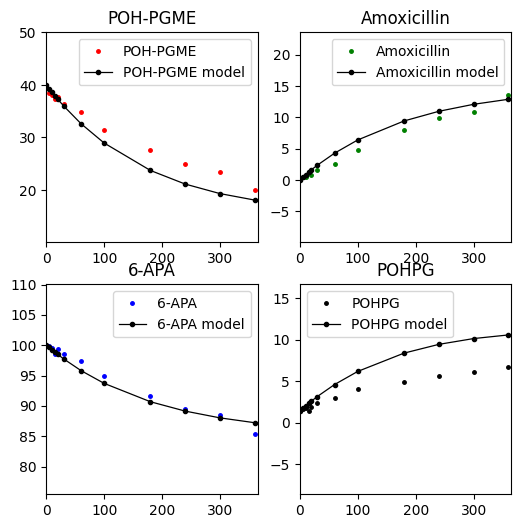

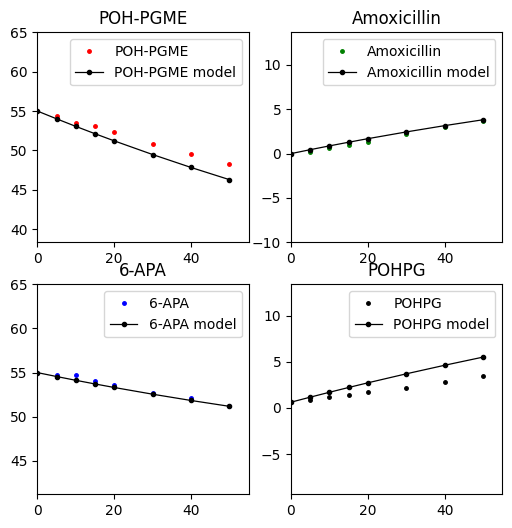

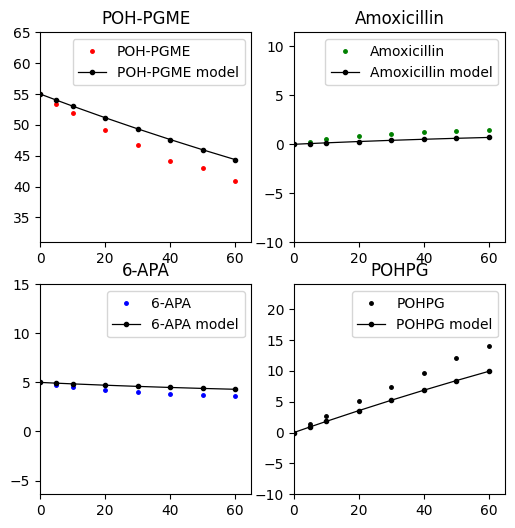

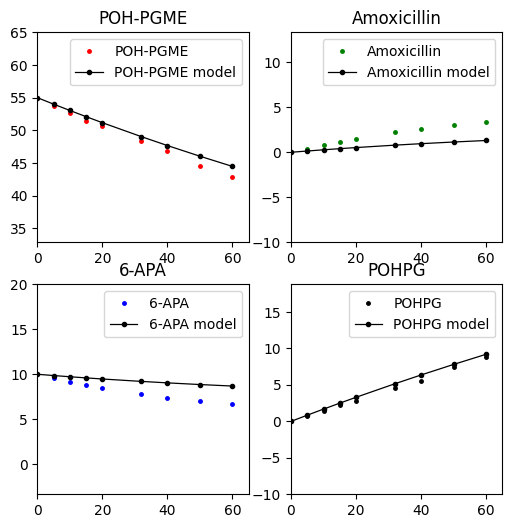

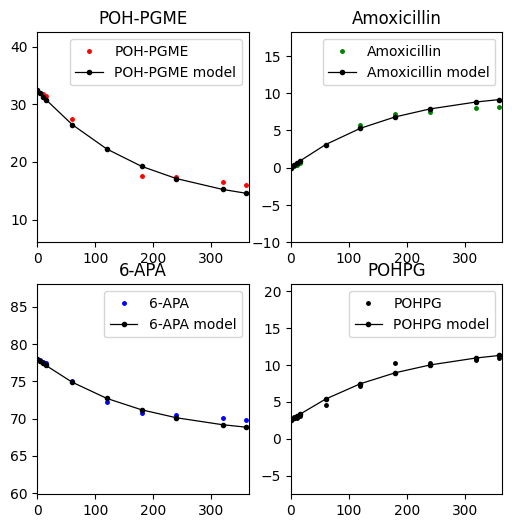

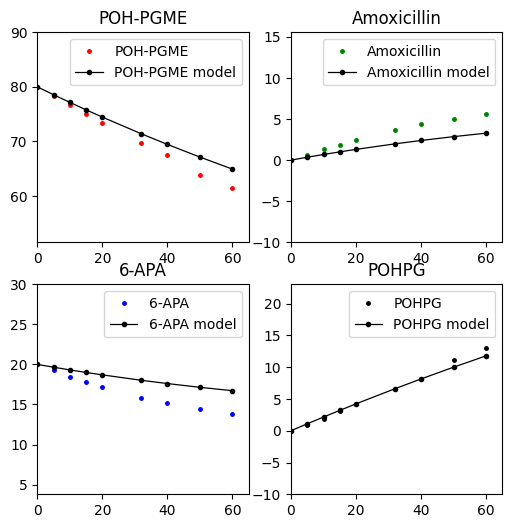

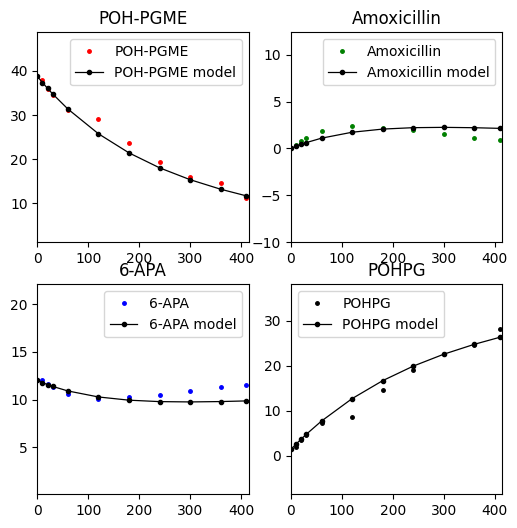

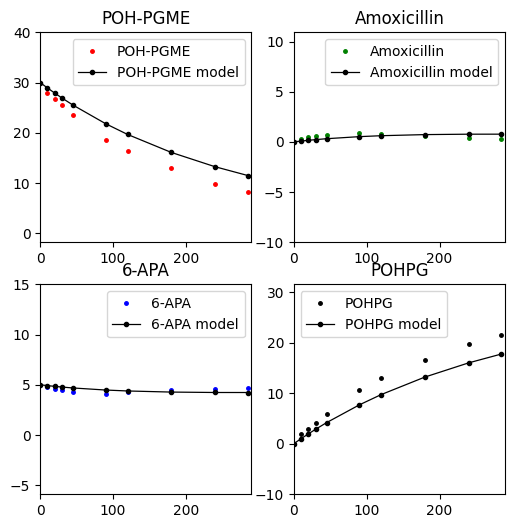

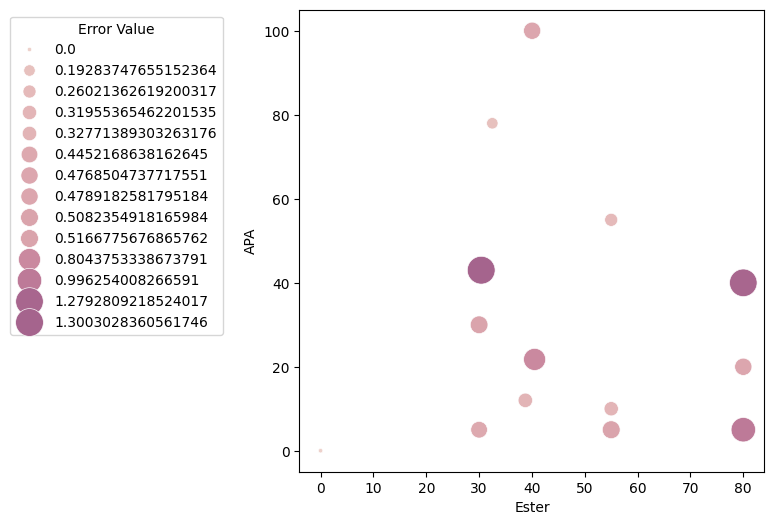

In [134]:
n = -4
par = copy.deepcopy(ensaios_dfs[eval_set[n]].iloc[0,:].to_list())
print(eval_set[n])
eval_performance(P,plot=False)
eval_performance(par,plot=True)
eval_all(par)

print(file_list_exp[n])
for idx,par in enumerate(par):
    print(labels[idx],': ',par)